# Gathering and Preprocessing of Data

In this phase , data is collected from various social media sites like Twitter and Reddit.

1. Collecting Data from Reddit

In [2]:
import praw
import pandas as pd
from praw.models import MoreComments
reddit = praw.Reddit(client_id='MjOYmV5QB4Q8bw', client_secret='Ha-Bem-WhpBXOFu6sQExGW1u760', user_agent='Scraping Example')

"""
# get 10 hot posts from the MachineLearning subreddit
hot_posts = reddit.subreddit('Cricket').hot(limit=10)
for post in hot_posts:
    print(post.title)
"""
#comments = []
comments=""
submission = reddit.submission(id="f1zmjl")
submission.comments.replace_more(limit=0)
for top_level_comment in submission.comments:
    comments = comments + top_level_comment.body
    #comments.append([top_level_comment.body])
#comments = pd.DataFrame(comments,columns=['comment'])
print(comments)
#comments.to_pickle('redditdataset.pkl')
comments.to_csv('redditdataset.csv', sep='\t', encoding='utf-8', index=False)

So this is the worst series of Kohli like in years.Saini ODI average at 53 😂SANTNER OVERRATED

NEESHAM OUTDATED

LONG HAVE WE AWAITED

LE BIG MAN HAS BEEN ACTIVATEDKohli running with Shaw is going to be interesting.

Edit: Oh my god![deleted]New bowler : *exists*

India : I am about to make this man's whole career.Fuck i'm excited for the future of long levers Jamieson. A handful to face and his cameo innings was no fluke he can swing the blade. Hit a century belting the piss out of a near full strength English bowling unit in a warm up. [Source](https://www.stuff.co.nz/sport/cricket/102273999/kyle-jamieson-gets-under-englands-skin-on-his-way-to-smashing-surreal-century)LOL Doull saying you need to post it on Twitter if you want Neesham to read itSaini was refusing the single due to his humbleness. He didn't want to show off his skills.NZ chasing down 300 when Taylor and Williamson score less than 40 combined makes me super happy.**Fastest fifty against India in ODIs**

18 Glenn Maxwel

AttributeError: 'str' object has no attribute 'to_csv'

In [3]:
from nltk.tokenize import sent_tokenize
tokenized_text=sent_tokenize(comments)
print(tokenized_text)

['So this is the worst series of Kohli like in years.Saini ODI average at 53 😂SANTNER OVERRATED\n\nNEESHAM OUTDATED\n\nLONG HAVE WE AWAITED\n\nLE BIG MAN HAS BEEN ACTIVATEDKohli running with Shaw is going to be interesting.', 'Edit: Oh my god!', "[deleted]New bowler : *exists*\n\nIndia : I am about to make this man's whole career.Fuck i'm excited for the future of long levers Jamieson.", 'A handful to face and his cameo innings was no fluke he can swing the blade.', 'Hit a century belting the piss out of a near full strength English bowling unit in a warm up.', '[Source](https://www.stuff.co.nz/sport/cricket/102273999/kyle-jamieson-gets-under-englands-skin-on-his-way-to-smashing-surreal-century)LOL Doull saying you need to post it on Twitter if you want Neesham to read itSaini was refusing the single due to his humbleness.', "He didn't want to show off his skills.NZ chasing down 300 when Taylor and Williamson score less than 40 combined makes me super happy.", "**Fastest fifty against 

In [4]:
import nltk
from nltk.tokenize import word_tokenize
tokenized_word=word_tokenize(comments)
print(tokenized_word)

['So', 'this', 'is', 'the', 'worst', 'series', 'of', 'Kohli', 'like', 'in', 'years.Saini', 'ODI', 'average', 'at', '53', '😂SANTNER', 'OVERRATED', 'NEESHAM', 'OUTDATED', 'LONG', 'HAVE', 'WE', 'AWAITED', 'LE', 'BIG', 'MAN', 'HAS', 'BEEN', 'ACTIVATEDKohli', 'running', 'with', 'Shaw', 'is', 'going', 'to', 'be', 'interesting', '.', 'Edit', ':', 'Oh', 'my', 'god', '!', '[', 'deleted', ']', 'New', 'bowler', ':', '*exists*', 'India', ':', 'I', 'am', 'about', 'to', 'make', 'this', 'man', "'s", 'whole', 'career.Fuck', 'i', "'m", 'excited', 'for', 'the', 'future', 'of', 'long', 'levers', 'Jamieson', '.', 'A', 'handful', 'to', 'face', 'and', 'his', 'cameo', 'innings', 'was', 'no', 'fluke', 'he', 'can', 'swing', 'the', 'blade', '.', 'Hit', 'a', 'century', 'belting', 'the', 'piss', 'out', 'of', 'a', 'near', 'full', 'strength', 'English', 'bowling', 'unit', 'in', 'a', 'warm', 'up', '.', '[', 'Source', ']', '(', 'https', ':', '//www.stuff.co.nz/sport/cricket/102273999/kyle-jamieson-gets-under-englands

# Applying TF-IDF to collected dataset

In [5]:
from nltk.probability import FreqDist
fdist = FreqDist(tokenized_word)
print(fdist)

<FreqDist with 2432 samples and 8120 outcomes>


In [6]:
fdist.most_common(2)


[('the', 257), (',', 199)]

In [7]:
# Frequency Distribution Plot
import matplotlib.pyplot as plt
fdist.plot(30,cumulative=False)
plt.show()


<Figure size 640x480 with 1 Axes>

In [8]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
print(stop_words)

{'is', 'weren', "you'll", 'yourself', 'about', 'its', 'being', 'only', "wasn't", 'own', 'ours', 'at', 'few', 't', 's', 'again', 'her', 'hasn', 'this', 'all', 'we', "that'll", 'am', 'they', 'how', 'these', 'between', 'm', 'themselves', 'a', 'and', "wouldn't", 'there', 'i', 'then', "won't", 'which', 'most', 'can', 'very', 'why', 'been', 'yourselves', 'theirs', 'too', 'she', 'have', 'were', 'from', 'his', 'of', 'an', 'hers', 'it', 'does', 'up', 'after', 've', 'itself', 'your', 'that', 'any', "you're", "you'd", 'off', 'was', 'other', "shouldn't", 'wasn', 'now', 'shan', 'as', 'to', 'here', 'no', 'needn', 'him', 'into', 'where', 'don', 'me', 'doesn', 'than', 'nor', "should've", 'should', 'ain', 'out', 'you', 'be', 'will', 'aren', 'until', 'some', "couldn't", 'before', 'above', "needn't", 'not', 'in', 'when', 'haven', 'once', 'each', 'are', 'with', 'below', 'hadn', "you've", 'couldn', 'o', 'down', 'isn', "weren't", 'had', 'so', 'shouldn', "hadn't", 'yours', "aren't", 'but', 'did', 'same', 'ov

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/warlock/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
filtered_sent = []
for w in tokenized_word:
    if w not in stop_words:
        filtered_sent.append(w)
#print("Tokenized Sentence:",tokenized_text)
print("Filterd Sentence:",filtered_sent)


Filterd Sentence: ['So', 'worst', 'series', 'Kohli', 'like', 'years.Saini', 'ODI', 'average', '53', '😂SANTNER', 'OVERRATED', 'NEESHAM', 'OUTDATED', 'LONG', 'HAVE', 'WE', 'AWAITED', 'LE', 'BIG', 'MAN', 'HAS', 'BEEN', 'ACTIVATEDKohli', 'running', 'Shaw', 'going', 'interesting', '.', 'Edit', ':', 'Oh', 'god', '!', '[', 'deleted', ']', 'New', 'bowler', ':', '*exists*', 'India', ':', 'I', 'make', 'man', "'s", 'whole', 'career.Fuck', "'m", 'excited', 'future', 'long', 'levers', 'Jamieson', '.', 'A', 'handful', 'face', 'cameo', 'innings', 'fluke', 'swing', 'blade', '.', 'Hit', 'century', 'belting', 'piss', 'near', 'full', 'strength', 'English', 'bowling', 'unit', 'warm', '.', '[', 'Source', ']', '(', 'https', ':', '//www.stuff.co.nz/sport/cricket/102273999/kyle-jamieson-gets-under-englands-skin-on-his-way-to-smashing-surreal-century', ')', 'LOL', 'Doull', 'saying', 'need', 'post', 'Twitter', 'want', 'Neesham', 'read', 'itSaini', 'refusing', 'single', 'due', 'humbleness', '.', 'He', "n't", 'wa

In [10]:
filt_sent_string = ' '.join(map(str, filtered_sent))   

import re
only_words = re.findall(r'\w+', filt_sent_string)
print(only_words)
type(only_words)


['So', 'worst', 'series', 'Kohli', 'like', 'years', 'Saini', 'ODI', 'average', '53', 'SANTNER', 'OVERRATED', 'NEESHAM', 'OUTDATED', 'LONG', 'HAVE', 'WE', 'AWAITED', 'LE', 'BIG', 'MAN', 'HAS', 'BEEN', 'ACTIVATEDKohli', 'running', 'Shaw', 'going', 'interesting', 'Edit', 'Oh', 'god', 'deleted', 'New', 'bowler', 'exists', 'India', 'I', 'make', 'man', 's', 'whole', 'career', 'Fuck', 'm', 'excited', 'future', 'long', 'levers', 'Jamieson', 'A', 'handful', 'face', 'cameo', 'innings', 'fluke', 'swing', 'blade', 'Hit', 'century', 'belting', 'piss', 'near', 'full', 'strength', 'English', 'bowling', 'unit', 'warm', 'Source', 'https', 'www', 'stuff', 'co', 'nz', 'sport', 'cricket', '102273999', 'kyle', 'jamieson', 'gets', 'under', 'englands', 'skin', 'on', 'his', 'way', 'to', 'smashing', 'surreal', 'century', 'LOL', 'Doull', 'saying', 'need', 'post', 'Twitter', 'want', 'Neesham', 'read', 'itSaini', 'refusing', 'single', 'due', 'humbleness', 'He', 'n', 't', 'want', 'show', 'skills', 'NZ', 'chasing',

list

In [11]:
mean_words = [i for i in only_words if not i.isdigit()]


final_words = [i for i in mean_words if len(i) > 1]
print(final_words)
type(final_words)

['So', 'worst', 'series', 'Kohli', 'like', 'years', 'Saini', 'ODI', 'average', 'SANTNER', 'OVERRATED', 'NEESHAM', 'OUTDATED', 'LONG', 'HAVE', 'WE', 'AWAITED', 'LE', 'BIG', 'MAN', 'HAS', 'BEEN', 'ACTIVATEDKohli', 'running', 'Shaw', 'going', 'interesting', 'Edit', 'Oh', 'god', 'deleted', 'New', 'bowler', 'exists', 'India', 'make', 'man', 'whole', 'career', 'Fuck', 'excited', 'future', 'long', 'levers', 'Jamieson', 'handful', 'face', 'cameo', 'innings', 'fluke', 'swing', 'blade', 'Hit', 'century', 'belting', 'piss', 'near', 'full', 'strength', 'English', 'bowling', 'unit', 'warm', 'Source', 'https', 'www', 'stuff', 'co', 'nz', 'sport', 'cricket', 'kyle', 'jamieson', 'gets', 'under', 'englands', 'skin', 'on', 'his', 'way', 'to', 'smashing', 'surreal', 'century', 'LOL', 'Doull', 'saying', 'need', 'post', 'Twitter', 'want', 'Neesham', 'read', 'itSaini', 'refusing', 'single', 'due', 'humbleness', 'He', 'want', 'show', 'skills', 'NZ', 'chasing', 'Taylor', 'Williamson', 'score', 'less', 'combin

list

In [12]:
# Converting List to String
filt_sent_string = ' '.join(map(str, final_words))

In [13]:
# Slicing the string into two to perform TF - IDF Algorithm
str_one, str_two = filt_sent_string[:len(filt_sent_string)//2],filt_sent_string[len(filt_sent_string)//2:] 
  
# printing result  
print("The first part of string : " + str_one) 
print("The second part of string : " + str_two) 


The first part of string : So worst series Kohli like years Saini ODI average SANTNER OVERRATED NEESHAM OUTDATED LONG HAVE WE AWAITED LE BIG MAN HAS BEEN ACTIVATEDKohli running Shaw going interesting Edit Oh god deleted New bowler exists India make man whole career Fuck excited future long levers Jamieson handful face cameo innings fluke swing blade Hit century belting piss near full strength English bowling unit warm Source https www stuff co nz sport cricket kyle jamieson gets under englands skin on his way to smashing surreal century LOL Doull saying need post Twitter want Neesham read itSaini refusing single due humbleness He want show skills NZ chasing Taylor Williamson score less combined makes super happy Fastest fifty India ODIs Glenn Maxwell Bengaluru Shahid Afridi Kanpur Dougie Marillier Faridabad de Grandhomme Mount Maunganui Jaddu like gully cricket bro gives strike bat too Saini averages bat ODIs lol Colin need score runs re going dropped team x200B Oh okFor every single o

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

In [15]:
response = tfidf.fit_transform([str_one, str_two])

In [16]:
feature_names = tfidf.get_feature_names()
for col in response.nonzero()[1]:
    print (feature_names[col], ' - ', response[0, col])

ba  -  0.013075546216742432
definitely  -  0.013075546216742432
origin  -  0.013075546216742432
punjabi  -  0.03922663865022729
khrriya  -  0.013075546216742432
kidhar  -  0.013075546216742432
retire  -  0.013075546216742432
said  -  0.009303358824996272
grandpa  -  0.013075546216742432
row  -  0.009303358824996272
50s  -  0.013075546216742432
afghanistan  -  0.013075546216742432
teams  -  0.013075546216742432
lowest  -  0.013075546216742432
lanka  -  0.009303358824996272
sri  -  0.009303358824996272
put  -  0.009303358824996272
individual  -  0.013075546216742432
looked  -  0.013075546216742432
syllabus  -  0.013075546216742432
championship  -  0.013075546216742432
preparation  -  0.013075546216742432
concentration  -  0.013075546216742432
meis  -  0.013075546216742432
rayuduthakur  -  0.013075546216742432
ambati  -  0.013075546216742432
dube  -  0.009303358824996272
scooby  -  0.013075546216742432
missing  -  0.009303358824996272
spannerpeople  -  0.013075546216742432
toes  -  0.0261

lack  -  0.009303358824996272
overs  -  0.03721343529998509
choice  -  0.013075546216742432
apart  -  0.018606717649992544
taken  -  0.03922663865022729
frontline  -  0.013075546216742432
if  -  0.027910076474988818
bowl  -  0.027910076474988818
lmaohow  -  0.013075546216742432
box  -  0.018606717649992544
nutted  -  0.013075546216742432
will  -  0.026151092433484863
rhythm  -  0.026151092433484863
praying  -  0.026151092433484863
always  -  0.03721343529998509
53like  -  0.013075546216742432
catch  -  0.009303358824996272
easiest  -  0.013075546216742432
feet  -  0.013075546216742432
twelve  -  0.013075546216742432
potentialjamieson  -  0.013075546216742432
fulfilling  -  0.013075546216742432
finisherkl  -  0.013075546216742432
knock  -  0.013075546216742432
continues  -  0.009303358824996272
form  -  0.018606717649992544
nerdsbrilliant  -  0.013075546216742432
dorky  -  0.013075546216742432
stumps  -  0.03922663865022729
next  -  0.009303358824996272
nerd  -  0.013075546216742432
who

match  -  0.08373022942496645
caps  -  0.013075546216742432
black  -  0.013075546216742432
rant  -  0.013075546216742432
topic  -  0.013075546216742432
apologize  -  0.009303358824996272
munroi  -  0.013075546216742432
miss  -  0.009303358824996272
game  -  0.08373022942496645
day  -  0.03721343529998509
another  -  0.027910076474988818
lawyer  -  0.013075546216742432
know  -  0.03721343529998509
anyone  -  0.009303358824996272
murder  -  0.013075546216742432
bird  -  0.026151092433484863
chahal  -  0.055820152949977636
implicating  -  0.013075546216742432
scotty  -  0.013075546216742432
hell  -  0.009303358824996272
wickets  -  0.102336947074959
watch  -  0.009303358824996272
amazing  -  0.026151092433484863
partnership  -  0.018606717649992544
that  -  0.018606717649992544
opening  -  0.046516794124981366
boult  -  0.027910076474988818
love  -  0.009303358824996272
would  -  0.08373022942496645
class  -  0.009303358824996272
hope  -  0.03721343529998509
2020i  -  0.013075546216742432

wicketsman  -  0.0
embodiment  -  0.0
bennet  -  0.0
azharuddin  -  0.0
cricbuzz  -  0.0
ind  -  0.0
successful  -  0.0
ishant  -  0.0
africa  -  0.0
south  -  0.0
indies  -  0.0
west  -  0.0
batindia  -  0.0
cdgs  -  0.0
yoh  -  0.0
surprised  -  0.0
tuned  -  0.0
literally  -  0.0
sweet  -  0.0
ago  -  0.0
minutes  -  0.0
where  -  0.0
toll  -  0.0
club  -  0.0
xi  -  0.0
2nd  -  0.0
grind  -  0.0
40s  -  0.0
older  -  0.0
version  -  0.0
6every  -  0.0
comes  -  0.0
anticipation  -  0.0
giddy  -  0.0
help  -  0.0
times  -  0.0
spud  -  0.0
casually  -  0.0
confirmedcdg  -  0.0
bradman  -  0.0
mistakecolin  -  0.0
lordship  -  0.0
elevated  -  0.0
siraj  -  0.0
binny  -  0.0
peers  -  0.0
official  -  0.0
khaleel  -  0.0
hopes  -  0.0
lmaoi  -  0.0
slander  -  0.0
starts  -  0.0
performing  -  0.0
bah  -  0.0
praising  -  0.0
nesham  -  0.0
blind  -  0.0
neeshneesh  -  0.0
released  -  0.0
tracked  -  0.0
bishnoi  -  0.0
bumrahcan  -  0.0
absence  -  0.0
memes  -  0.0
for  -  0.0
dis

intl  -  0.009303358824996272
needed  -  0.009303358824996272
never  -  0.018606717649992544
short  -  0.009303358824996272
keep  -  0.027910076474988818
chokers  -  0.009303358824996272
biggest  -  0.009303358824996272
wtf  -  0.009303358824996272
at  -  0.018606717649992544
taste  -  0.009303358824996272
commentator  -  0.009303358824996272
grand  -  0.009303358824996272
koach  -  0.009303358824996272
selection  -  0.009303358824996272
anything  -  0.018606717649992544
change  -  0.009303358824996272
wish  -  0.018606717649992544
currently  -  0.009303358824996272
giving  -  0.009303358824996272
anymore  -  0.009303358824996272
rounders  -  0.009303358824996272
solid  -  0.009303358824996272
this  -  0.03721343529998509
kids  -  0.009303358824996272
kiwi  -  0.018606717649992544
him  -  0.009303358824996272
rotate  -  0.009303358824996272
bit  -  0.018606717649992544
seems  -  0.009303358824996272
shows  -  0.009303358824996272
wc  -  0.009303358824996272
consecutive  -  0.0093033588

In [20]:
print(feature_names)

['00neesham', '07wtf', '0feeling', '0there', '100plus', '100s', '102saini', '120s', '130s', '140km', '150kphno', '1cdg', '1st', '2001kohli', '200old', '2020i', '272i', '2nd', '300saini', '30s', '30th', '37th', '3rd', '40s', '42nd', '46th', '4th', '50nz', '50s', '53like', '5th', '6every', '6s', '6th', '71the', '8saini', '8th', '9archer', 'abandoned', 'able', 'absence', 'absolute', 'acceleration', 'accent', 'accurate', 'achievable', 'activatedkohli', 'activatedto', 'actually', 'adamant', 'advanced', 'advantage', 'aesthetically', 'afghanistan', 'africa', 'afridi', 'after', 'againjadeja', 'againthis', 'agarwal', 'agent', 'aggarwal', 'aggression', 'aggressive', 'aggressively', 'ago', 'ah', 'ahead', 'aheadthis', 'aight', 'aim', 'alert', 'alivefucking', 'all', 'almost', 'already', 'alright', 'also', 'always', 'amazing', 'ambati', 'amongst', 'amount', 'ancient', 'and', 'anderson', 'another', 'anticipation', 'anymore', 'anyone', 'anything', 'anyways', 'anywhere', 'apart', 'apologize', 'apparent

In [1]:
#import csv

#with open('redditdataset.csv', newline='') as f:
    #reader = csv.reader(f)
    #data = list(reader)

#print(data)

# Sentiment Analysis using NLTK

In [3]:
import pandas as pd
messages = [line.rstrip() for line in open("redditdataset.csv")]
data = pd.read_csv("redditdataset.csv",sep="\n",names=["message"])

In [7]:
data["message"][1]
#just to check if datacorpus is loaded currectly.

'So this is the worst series of Kohli like in years.'

In [11]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/warlock/nltk_data...


True

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [13]:
sid = SentimentIntensityAnalyzer()

In [15]:
summary = {"positive":0,"neutral":0,"negative":0}
for x in messages: 
    ss = sid.polarity_scores(x)
    if ss["compound"] == 0.0: 
        summary["neutral"] +=1
    elif ss["compound"] > 0.0:
        summary["positive"] +=1
    else:
        summary["negative"] +=1
print(summary)

{'positive': 206, 'neutral': 448, 'negative': 140}


In [16]:
type(summary)

dict

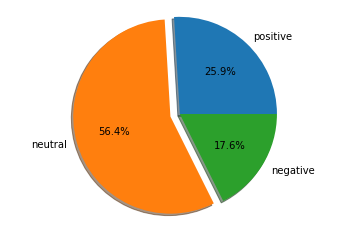

In [51]:
import matplotlib.pyplot as plt
labels = tuple(summary.keys())
sizes = list(summary.values())
explode = (0, 0.1, 0)
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True)
plt.axis('equal')
plt.show()